# Basic Statistics 6 Minute Test Dataset
The test dataset is from 26th September 2015:
`Cam_1_2015-09-26T13/27/48.634901Z--2015-09-26T13/33/29.650405Z.bbb`

In [1]:
%matplotlib inline

import os
import statistics
from collections import Counter
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from bb_binary import FrameContainer, Repository

matplotlib.rc("figure", figsize=(12,6))
sns.set_style("white")

repo = Repository("/Users/alexa/Projects/bees-sna/2015/")

## Looking at properties of FrameContainer

In [2]:
for fname in repo.iter_fnames():
    print(fname)
    with open(fname, 'rb') as f:
        fc = FrameContainer.read(f)
        fromTs = fc.fromTimestamp
        toTs = fc.toTimestamp
        camId = fc.camId

/Users/alexa/Projects/bees-sna/2015/09/26/13/20/Cam_1_2015-09-26T13:27:48.634901Z--2015-09-26T13:33:29.650405Z.bbb


In [3]:
print(fromTs)
print(toTs)
print(toTs-fromTs)
print(camId)

1443274068.634901
1443274409.650406
341.01550483703613
1


## Looking at the Frames and Detections

In [4]:
frame_count = 0
detection_count = 0
detection_counts = []

for frame, detection in repo.iter_frames():
    frame_count = frame_count + 1
    for detection in frame.detectionsUnion.detectionsDP:
        detection_count += 1
    detection_counts.append(detection_count)
    detection_count = 0 

Number of Frames

In [5]:
frame_count

1024

## Number of Detections per Frame

In [6]:
a = np.array(detection_counts)
print("Average: {}".format(np.average(a)))
print("Max: {}".format(np.max(a)))
print("Min: {}".format(np.min(a)))
print("Mean: {}".format(np.mean(a)))
print("Median: {}".format(np.median(a)))
print("Sum: {}".format(np.sum(a)))

Average: 88.2763671875
Max: 98
Min: 78
Mean: 88.2763671875
Median: 88.0
Sum: 90395


In [7]:
print(stats.mode(a))

ModeResult(mode=array([87]), count=array([131]))


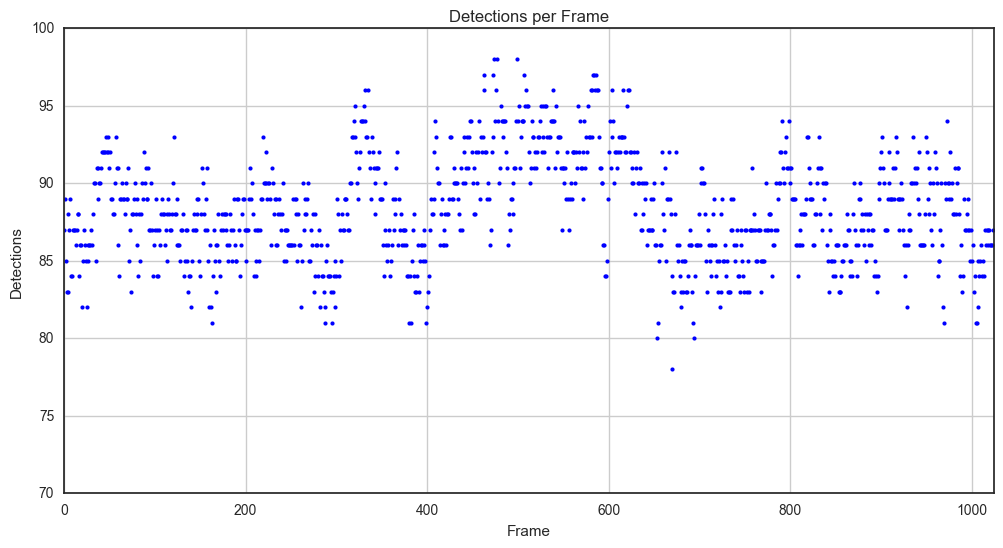

In [8]:
plt.plot(detection_counts, 'bo', markersize=3)

plt.xlabel('Frame')
plt.ylabel('Detections')
plt.title('Detections per Frame')
plt.axis([0, 1024, 70, 100])
plt.grid(True)

plt.show()

## How many 'good' IDs per FrameContainer?
12 bit per ID, e.g.:
[255, 255, 255, 255, 254, 0, 0, 0, 0, 0, 255, 0]
[204, 245, 229, 225, 43, 73, 233, 253, 24, 194, 65, 142]
Divide by 255 to get 0 or 1, I guess "runden" is ok?
What values mean good enought?
Does it make a difference: calculate quality in total per FrameContainer or per Frame?

In [9]:
detections = []
for frame, detection in repo.iter_frames():
    for detection in frame.detectionsUnion.detectionsDP:
        detections.append(detection.decodedId)
    
print(detections[0])
print(detections[1])
print(detections[2])

[255, 255, 255, 255, 254, 0, 0, 0, 0, 0, 255, 0]
[204, 245, 229, 225, 43, 73, 233, 253, 24, 194, 65, 142]
[0, 255, 0, 255, 255, 255, 0, 255, 0, 0, 255, 0]


In [18]:
# Offset, what is called a good quality detection
delta = 256/4 #127

counter = 0
for det in detections:
    c = 0
    for bit in det:
        if (bit <= 0 + delta) or (bit >= 255 - delta):
            c = c + 1
    if c == 12:
        counter = counter + 1

        
percentage = (counter * 100)/len(detections)

In [19]:
print(len(detections))
print(counter)
print(percentage)

90395
74163
82.04325460479009


Looking at the decoded IDs for each delta. To answer the question: What delta is enough to have a enough data to work with.

In [12]:
quality = []

for i in range(128):
    delta = i

    counter = 0
    for det in detections:
        c = 0
        for bit in det:
            if (bit <= 0 + delta) or (bit >= 255 - delta):
                c = c + 1
        if c == 12:
            counter = counter + 1
    quality.append((i,counter))

In [13]:
print(quality)

[(0, 38374), (1, 48409), (2, 52458), (3, 54956), (4, 56694), (5, 57994), (6, 59046), (7, 59903), (8, 60655), (9, 61382), (10, 62000), (11, 62549), (12, 63085), (13, 63518), (14, 63913), (15, 64279), (16, 64652), (17, 64981), (18, 65317), (19, 65623), (20, 65900), (21, 66172), (22, 66422), (23, 66674), (24, 66949), (25, 67200), (26, 67428), (27, 67673), (28, 67900), (29, 68126), (30, 68346), (31, 68546), (32, 68731), (33, 68941), (34, 69149), (35, 69339), (36, 69527), (37, 69733), (38, 69912), (39, 70101), (40, 70299), (41, 70458), (42, 70641), (43, 70807), (44, 70966), (45, 71137), (46, 71297), (47, 71461), (48, 71618), (49, 71786), (50, 71951), (51, 72114), (52, 72263), (53, 72443), (54, 72600), (55, 72738), (56, 72900), (57, 73064), (58, 73233), (59, 73408), (60, 73568), (61, 73707), (62, 73853), (63, 74017), (64, 74163), (65, 74331), (66, 74488), (67, 74654), (68, 74795), (69, 74955), (70, 75096), (71, 75239), (72, 75427), (73, 75601), (74, 75751), (75, 75906), (76, 76063), (77, 762

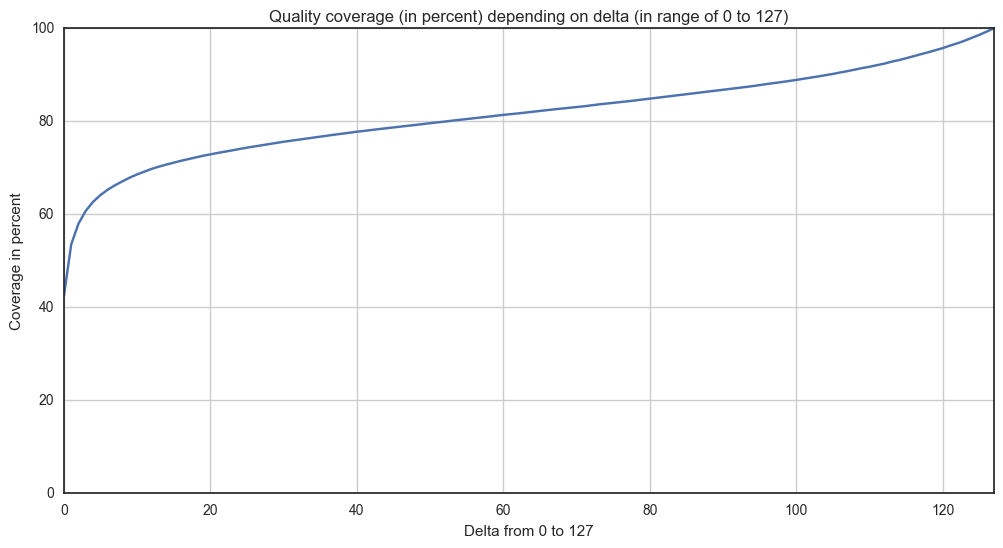

In [14]:
total = len(detections)
list = [(elem1, (elem2*100)/total) for elem1, elem2 in quality]
plt.plot(*zip(*list))
plt.xlabel('Delta from 0 to 127')
plt.ylabel('Coverage in percent')
plt.title('Quality coverage (in percent) depending on delta (in range of 0 to 127)')
plt.axis([0, 127, 0, 100])
plt.grid(True)